In [1]:
import torch
import torch.nn as nn
from torch.nn.modules import loss
import torch.optim as optim

import numpy as np
from numpy.random import default_rng
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage import uniform_filter1d
from scipy.stats import gaussian_kde
from celluloid import Camera

rng = default_rng(900)

cuda = False
DEVICE = torch.device("cuda" if cuda else "cpu")

In [2]:
# neural network parameters
mb_size = 256 # mini batch dim
h_Q_dim = 512*6 # encoder dim
h_P_dim = 512*6 # decoder dim

lr = 1e-4 # learning rate

# problem dimenc_dimsions
nDrawnSamples = 49 # number of dependent samples to draw during smapling (length of predicted control series)
nPreviousStates = 1 # number of previous states to condition on the steering prediction
dim = 7 # (truckX, truckY, truckYaw, truckX, trailerY, trailerYaw, steer)
dimGoal = 3
dimObs = 3*2
dimPredict = dim - 0 # predict truck (truckX, truckY, truckYaw, steer)
dataElements = (nDrawnSamples + nPreviousStates) * dim + dimGoal + dimObs # steer sample, current pose (3D: x,y,yaw), goal (3D), dimObs (2D x 3)

z_dim = 3 # latent dim
X_dim = nDrawnSamples*dimPredict
c_dim = dataElements - X_dim # dimension of conditioning variable

gridSize = 11

In [3]:
# read in data from .txt file, re-arrange to allow drawing multiple depedent samples

filename = '/home/oscar_palfelt/MSc_thesis/EECS_Degree_Project/learn_control/truck_trailer/motion_planning/data/mapD_data_27kPlans'
rawdata = np.genfromtxt(filename, delimiter=',', dtype='d', usecols=[0,1,2,3,4,5,6,10,11,12,13,14,15,16,17,18]) # disregard init

_, pathsIdx = np.unique(rawdata[:,dim:], axis=0, return_index=True)
pathsIdx.sort()

pathsLengths = np.roll(pathsIdx, -1) - pathsIdx
pathsLengths[-1] = rawdata.shape[0] - np.sum(pathsLengths[:-1])

validLengthsIdx = np.argwhere(pathsLengths >= nPreviousStates + nDrawnSamples) 
validPlansIdx = pathsIdx[validLengthsIdx]

data = np.zeros(shape=(1, dataElements)) # steering angles, samples (x,y,yaw), goal(x,y,yaw)
tempdata = np.copy(data)
for ci, i in enumerate(validPlansIdx[:-1].reshape(-1)):
    for j in range(pathsLengths[ci] - (nPreviousStates + nDrawnSamples - 1)):
        sample = np.arange(start=j, stop=j + nPreviousStates + nDrawnSamples)

        if np.any(np.abs(np.diff(rawdata[i + sample, 0])) > 0.05) or np.any(np.abs(np.diff(rawdata[i + sample, 1])) > 0.05):
            break # ignore duplicate plans (data generation is not perfect)
        
        seqstates = rawdata[i + sample, :dim].reshape(1, (nPreviousStates + nDrawnSamples)*dim)
        # filter out paths that has near zero steering input
        if np.where(np.abs(seqstates[0, 4:(nPreviousStates + nDrawnSamples)*dim:dim]) < 3e-2)[0].shape[0] >= (nDrawnSamples + nPreviousStates) // 1.2:
            continue

        tempdata = np.vstack((tempdata, np.append(seqstates, rawdata[i, dim:].reshape(1, dimGoal+dimObs), axis=1))) 
        # smoothen steering
        tempdata[-1, 4:(nPreviousStates + nDrawnSamples)*dim:dim] = uniform_filter1d(np.poly1d(np.polyfit(np.arange(nPreviousStates + nDrawnSamples), tempdata[-1, 4:(nPreviousStates + nDrawnSamples)*dim:dim], 9))(np.arange(nPreviousStates + nDrawnSamples)), size=7, origin=0, mode='nearest', axis=0)

        if ci % 500 == 0:
            data = np.vstack((data, tempdata[1:]))
            tempdata = np.zeros(shape=(1, dataElements))

data = data[1:]

rng.shuffle(data) # shuffle data (otherwise the data is sorted by obstacles/the map)

pathData = np.copy(data[:, :-dimObs])
obsData = np.copy(data[:, -dimObs:])

numEntries = pathData.shape[0]
print(numEntries)

51202


In [4]:
# split the inputs and conditions into test train (to be processed in the next step into an occupancy grid representation)

ratioTestTrain = 0.8;
numTrain = int(numEntries*ratioTestTrain)

x = pathData[:, dim * nPreviousStates:-dim+1:dim]
y = pathData[:, 1 + dim * nPreviousStates:-dim+2:dim]
yaw = pathData[:, 2 + dim * nPreviousStates:-dim+3:dim]
steer = pathData[:, 4 + dim * nPreviousStates:-dim+5:dim]
tx = pathData[:, 5 + dim * nPreviousStates:-dim+6:dim]
ty = pathData[:, 6 + dim * nPreviousStates:-dim+6:dim]
tyaw = pathData[:, 3 + dim * nPreviousStates:-dim+4:dim]

X = np.zeros(shape=(numEntries, X_dim))
X[:, ::dimPredict] = x
X[:, 1::dimPredict] = y
X[:, 2::dimPredict] = yaw
X[:, 3::dimPredict] = steer
X[:, 4::dimPredict] = ty
X[:, 5::dimPredict] = tx
X[:, 6::dimPredict] = tyaw

X_train = X[:numTrain]
X_test = X[numTrain:numEntries]

numTest = X_test.shape[0]

print(X_train.shape)

(40961, 343)


In [5]:
# generate conditioning variable

nextStates = pathData[:, nPreviousStates*dim:-dimGoal]

prevStatesConditions = pathData[:, :nPreviousStates * dim]
goalStateCondition = pathData[:, -dimGoal:]

conditionsOcc = np.zeros(shape=(numEntries, gridSize ** 2))
for i, row in enumerate(obsData):
    occGrid = np.zeros(shape=[gridSize, gridSize])
    VRT = row[:dimObs//2]
    HOR = row[dimObs//2:]
    occGrid[:, (VRT * (gridSize - 1)).astype(int)] = 1
    occGrid[((1 - HOR) * (gridSize - 1)).astype(int), :] = 1

    conditionsOcc[i] = occGrid.reshape(-1)

cs = np.concatenate((prevStatesConditions, goalStateCondition, conditionsOcc), axis=1)

c_train = cs[0:numTrain,:]  
c_test = cs[numTrain:numEntries,:]

print(cs.shape)

(51202, 131)


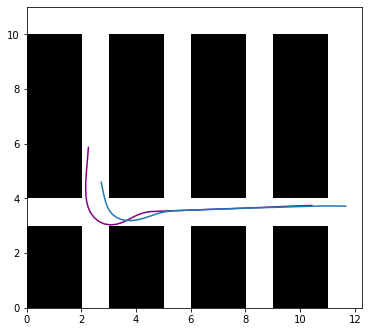

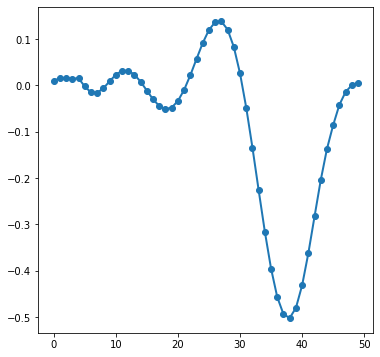

In [9]:
# Visualize random data sample

plt.figure(figsize=(6,6))
i = np.random.randint(1,numEntries)
plt.imshow(cs[i, -gridSize ** 2:].reshape(gridSize, gridSize), extent=[0, gridSize, 0, gridSize], cmap='gray')
plt.plot(pathData[i, :-dim:dim] * gridSize, pathData[i, 1:-dim:dim] * gridSize, color='purple')
plt.plot(pathData[i, 5:-dim:dim] * gridSize, pathData[i, 6:-dim:dim] * gridSize, color='C0')
plt.show()

plt.figure(figsize=(6,6))
plt.plot(np.arange(nPreviousStates + nDrawnSamples), pathData[i, 4:-dim+4:dim], 'o-', linewidth=2)
plt.show()

In [10]:
# define pytorch networks
# based on https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/blob/master/.ipynb_checkpoints/01_Variational_AutoEncoder-checkpoint.ipynb

class Encoder(nn.Module):
    
    def __init__(self, input_dim=X_dim+c_dim, hidden_dim=h_Q_dim, latent_dim=z_dim):
        super(Encoder, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        self.z_mu = nn.Linear(hidden_dim, latent_dim)
        self.z_logvar = nn.Linear(hidden_dim, latent_dim)
        
    def forward(self, x):

        seq = self.network(x)

        return self.z_mu(seq), self.z_logvar(seq)


class Decoder(nn.Module):
    def __init__(self, latent_dim=z_dim+c_dim, hidden_dim=h_P_dim, output_dim=X_dim):
        super(Decoder, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        
        return self.network(x)


class NeuralNetwork(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(NeuralNetwork, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
    
    def reparameterization(self, mean, logvar):
        epsilon = torch.randn_like(mean).to(DEVICE)        # sampling epsilon        
        z = mean + torch.exp(0.5 * logvar) * epsilon       # reparameterization trick
        return z

    def forward(self, x, c, encode=True):
        if encode:

            z_mu, z_logvar = self.Encoder(torch.cat((x, c), dim=1))
            z = self.reparameterization(z_mu, z_logvar)

            y = self.Decoder(torch.cat((z, c), dim=1))

            return y, z_mu, z_logvar
        else:
            z = x
            y = self.Decoder(torch.cat((z, c), dim=1))    

            return y


encoder = Encoder()
decoder = Decoder()
network = NeuralNetwork(Encoder=encoder, Decoder=decoder).to(DEVICE)

weight = torch.from_numpy(1 / np.max(np.abs(X),axis=0)).float().to(DEVICE)

def loss_function(x, y, mean, logvar):
    recon_loss = (weight * (x - y) ** 2).mean()
    kl_loss    = 10**-4 * 2 * torch.sum(torch.exp(logvar) + mean.pow(2) - 1. - logvar, dim=1)

    return torch.mean(kl_loss + recon_loss)

optimizer = optim.Adam(network.parameters(), lr=lr)


In [ ]:
# Training
for it in range(100001):
    # randomly generate batches
    batch_elements = [np.random.randint(0,numTrain-1) for n in range(0,mb_size)]

    X_mb = torch.tensor(X_train[batch_elements,:], requires_grad=True, dtype=torch.float32, device=DEVICE)
    c_mb = torch.tensor(c_train[batch_elements,:], requires_grad=True, dtype=torch.float32, device=DEVICE)

    optimizer.zero_grad()

    y, z_mu, z_logvar = network(X_mb, c_mb)
    
    loss = loss_function(X_mb, y, z_mu, z_logvar)
    loss.backward()
    optimizer.step()

    if it % 1000 == 0:
        batch_elements = [np.random.randint(0,numTest-1) for n in range(0,mb_size)]

        Xval_mb = torch.tensor(X_test[batch_elements,:], requires_grad=False, dtype=torch.float32, device=DEVICE)
        cval_mb = torch.tensor(c_test[batch_elements,:], requires_grad=False, dtype=torch.float32, device=DEVICE)

        yval, z_muval, z_logvarval = network(Xval_mb, cval_mb)

        valloss = loss_function(Xval_mb, yval, z_muval, z_logvarval)

        print('Iter: {}'.format(it))
        print('Loss: {:.4}'. format(loss))
        print('VLoss: {:.4} \n'. format(valloss))

In [12]:
uniqueMapInd = [] # c_test indicies that have a maximum of one training plan on that map
for i, c in enumerate(c_test):
    if np.where((c_train[:, -gridSize**2:] == c[-gridSize ** 2:]).all(axis=1))[0].shape[0] <= 1:
        uniqueMapInd.append(i)

Number of equal training maps: 1


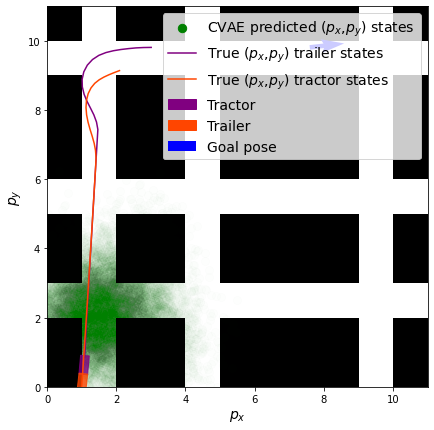

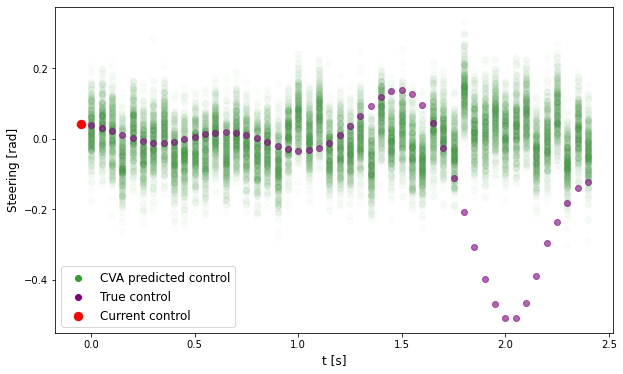

In [13]:
# plot the latent space
num_viz = 400 # number of samples to draw in latent space

L   = 0.05 # vehicle length constant
W   = 0.023 # truck/trailer width
v = 0.1 # vehicle speed
Lt  = 0.18 # truck length constant
a11 = 0.5 * L
a12 = L - a11
b1  = 0.9 * a12
b2  = 0.5 * Lt 
a21 = Lt - b2

vizIdx = np.random.choice(uniqueMapInd) # np.random.randint(0,numTest-1) # chose a random test scenario
c_sample_seed = c_test[vizIdx,:]

print("Number of equal training maps: {}".format(np.where((c_train[:, -gridSize**2:] == c_sample_seed[-gridSize ** 2:]).all(axis=1))[0].shape[0]))

c_sample = torch.from_numpy(np.repeat([c_sample_seed],num_viz,axis=0)).float().to(DEVICE)

y_viz = network(torch.randn(num_viz, z_dim).to(DEVICE), c_sample, encode=False).cpu().detach().numpy() # y_viz is sample in state space, zviz in latent space (3D)
t = np.tile(np.arange(nDrawnSamples), reps=(num_viz, 1)) * 0.05

xPrev = prevStatesConditions[numTrain + vizIdx, ::dim]
yPrev = prevStatesConditions[numTrain + vizIdx, 1::dim]
yawPrev = prevStatesConditions[numTrain + vizIdx, 2::dim]
tyawPrev = prevStatesConditions[numTrain + vizIdx, 3::dim]
steerPrev = prevStatesConditions[numTrain + vizIdx, 4::dim]

xNext = nextStates[numTrain + vizIdx, ::dim]
yNext = nextStates[numTrain + vizIdx, 1::dim]
xTruckNext = nextStates[numTrain + vizIdx, 5::dim]
yTruckNext = nextStates[numTrain + vizIdx, 6::dim]
steerNext = nextStates[numTrain + vizIdx, 4::dim]

fig1, ax1 = plt.subplots(1, 1, figsize=(7,7))
ax1.scatter(y_viz[:,::dimPredict] * gridSize, y_viz[:,1::dimPredict] * gridSize, color='green', s=70, alpha=0.006, label='CVAE predicted ($p_x$,$p_y$) states') # nn samples
ax1.plot(xNext * gridSize, yNext * gridSize, color='purple', label='True ($p_x$,$p_y$) trailer states') # true next trailer poses
ax1.plot(xTruckNext * gridSize, yTruckNext * gridSize, color='orangered', label='True ($p_x$,$p_y$) tractor states') # true next trailer poses
rectTruck = patches.Rectangle(((xPrev[-1] - np.cos(yawPrev[-1]) * L/2 + np.sin(yawPrev[-1]) * W/2) * gridSize, 
            (yPrev[-1] - np.cos(yawPrev[-1]) * W/2 - np.sin(yawPrev[-1]) * L/2) * gridSize), L * gridSize, W * gridSize, angle=np.rad2deg(yawPrev[-1]), color='purple', alpha=0.8, label='Tractor')
rectTrailer = patches.Rectangle(((xPrev[-1] - b1 * np.cos(yawPrev) - b2 / 2 * np.cos(tyawPrev) - np.cos(tyawPrev[-1]) * b2/2 + np.sin(tyawPrev[-1]) * W/2) * gridSize, 
            (yPrev[-1] - b1 * np.sin(yawPrev) - b2 / 2 * np.sin(tyawPrev) - np.cos(tyawPrev[-1]) * W/2 - np.sin(tyawPrev[-1]) * b2/2) * gridSize), b2 * gridSize, W * gridSize, angle=np.rad2deg(tyawPrev[-1]), color='orangered', alpha=0.8, label='Trailer')
ax1.add_patch(rectTruck)
ax1.add_patch(rectTrailer)
ax1.quiver(goalStateCondition[numTrain + vizIdx, 0] * gridSize, goalStateCondition[numTrain + vizIdx, 1] * gridSize, np.cos(goalStateCondition[numTrain + vizIdx, 2]), np.sin(goalStateCondition[numTrain + vizIdx, 2]), color="blue", scale=11.0, width=0.012, label='Goal pose') # goal
ax1.imshow(conditionsOcc[numTrain + vizIdx].reshape(gridSize, gridSize), extent=[0, gridSize, 0, gridSize], cmap='gray')
ax1.set_xlabel('$p_x$', fontsize=14)
ax1.set_ylabel('$p_y$', fontsize=14)
leg = ax1.legend(loc='upper right', fontsize=14)
for lh in leg.legendHandles:
    if not lh.get_alpha() is None:
        lh.set_alpha(1)

fig2, ax2 = plt.subplots(1, 1, figsize=(10,6))
ax2.scatter(t, y_viz[:, 3::dimPredict], alpha=0.02, color='C2', label='CVA predicted control') # Predict
ax2.scatter(t[0], steerNext, alpha = 0.6, color='purple', label='True control') # True
ax2.scatter(np.arange(-nPreviousStates, 0) * 0.05, steerPrev, s=70, color='red', label='Current control') # Previous
ax2.set_xlabel('t [s]', fontsize=12)
ax2.set_ylabel('Steering [rad]', fontsize=12)
leg = ax2.legend(fontsize=12)
for lh in leg.legendHandles:
    if not lh.get_alpha() is None:
        lh.set_alpha(1)

plt.show()

In [ ]:
# simulate truck + trailer using inputs from CVAE

class VehicleState():
    def __init__(self):
        self.x = 0
        self.y = 0
        self.yaw = 0
        self.v = 0

dt = 0.2 # time step

nPredictCtrlSteps = 49 # number of steps to simulate the car for using a single prediction

truckState = VehicleState()
truckState.x = xPrev[0]; truckState.y = yPrev[0]; truckState.yaw = yawPrev[0]

trailerState = VehicleState()
trailerState.yaw = tyawPrev[0]
trailerState.x = truckState.x - b1 * np.cos(truckState.yaw) -  b2 * np.cos(trailerState.yaw)
trailerState.y = truckState.y - b1 * np.sin(truckState.yaw) -  b2 * np.sin(trailerState.yaw)

kdes = np.array([gaussian_kde(y_viz[:, i * dim - 4]) for i in range(1, nPredictCtrlSteps + 1)])

maxSteer = np.max(pathData[:, 4::dim])
minSteer = np.min(pathData[:, 4::dim])
steerAngles = np.linspace(minSteer, maxSteer, num=200)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8), gridspec_kw={'width_ratios': [3, 2]})
camera = Camera(fig)

for kde in kdes:

    delta = steerAngles[np.argmax(kde.pdf(steerAngles))]

    beta = np.arctan(np.tan(delta) * a12 / (a11 + a12))

    trailerState.x = truckState.x - b1 * np.cos(truckState.yaw) - b2 * np.cos(trailerState.yaw)
    trailerState.y = truckState.y - b1 * np.sin(truckState.yaw) - b2 * np.sin(trailerState.yaw)
    trailerState.yaw += (v * np.sin(truckState.yaw - trailerState.yaw) / (b2 + a21) - v * (b1 - a12) * np.cos(truckState.yaw - trailerState.yaw) * np.sin(beta) / (a12 * (b2 + a21))) * dt

    truckState.x += v * np.cos(truckState.yaw + beta) * dt
    truckState.y += v * np.sin(truckState.yaw + beta) * dt
    truckState.yaw += v * np.sin(beta) / a12 * dt

    ax1.scatter(y_viz[:,::dimPredict] * gridSize, y_viz[:,1::dimPredict] * gridSize, color='green', s=70, alpha=0.006, label='CVAE predicted (x,y) states') # nn samples
    ax1.quiver(goalStateCondition[numTrain + vizIdx, 0] * gridSize, goalStateCondition[numTrain + vizIdx, 1] * gridSize, np.cos(goalStateCondition[numTrain + vizIdx, 2]), np.sin(goalStateCondition[numTrain + vizIdx, 2]), color="blue", scale=11.0, width=0.012, label='Goal pose') # goal
    rectTruck = patches.Rectangle(((truckState.x - np.cos(truckState.yaw) * L/2 + np.sin(truckState.yaw) * W/2) * gridSize, 
                (truckState.y - np.cos(truckState.yaw) * W/2 - np.sin(truckState.yaw) * L/2) * gridSize), L * gridSize, W * gridSize, angle=np.rad2deg(truckState.yaw), color='purple', alpha=0.8, label='Tractor')
    rectTrailer = patches.Rectangle(((truckState.x - b1 * np.cos(truckState.yaw) - b2 / 2 * np.cos(trailerState.yaw) - np.cos(trailerState.yaw) * b2/2 + np.sin(trailerState.yaw) * W/2) * gridSize, 
                (truckState.y - b1 * np.sin(truckState.yaw) - b2 / 2 * np.sin(trailerState.yaw) - np.cos(trailerState.yaw) * W/2 - np.sin(trailerState.yaw) * b2/2) * gridSize), b2 * gridSize, W * gridSize, angle=np.rad2deg(trailerState.yaw), color='orangered', alpha=0.8, label='Trailer')
    ax1.add_patch(rectTruck)
    ax1.add_patch(rectTrailer)
    ax1.imshow(conditionsOcc[numTrain + vizIdx].reshape(gridSize, gridSize), extent=[0, gridSize, 0, gridSize], cmap='gray')
    ax1.set_xlabel('x', fontsize=12)
    ax1.set_ylabel('y', fontsize=12)

    ax2.scatter(t, y_viz[:, 3::dimPredict], alpha=0.02, color='C2', label='CVA predicted control') # Predict
    ax2.scatter(t[0], steerNext, alpha = 0.6, color='purple', label='True control') # True
    ax2.scatter(np.arange(-nPreviousStates, 0) * 0.05, steerPrev, s=70, color='red', label='Current control') # Previous
    ax2.set_xlabel('t', fontsize=12)
    ax2.set_ylabel('Steering', fontsize=12)
    plt.show()

    camera.snap()

fps = 15
animation = camera.animate(interval=1000/fps)
print("saving animation")
animation.save('animation.mp4')